# Classification for place de marché : TransferLearning using VGG16 model

Now the feasability is established, we will continue to supervised classification

We will : 
- Split our data set
- Augment our data
- Train our model
- Predict our classes

In [51]:
# classic Librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import shutil


from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn import cluster
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from sklearn.metrics.cluster import adjusted_rand_score

from sklearn.model_selection import StratifiedShuffleSplit

# librairies for NLP
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras import metrics as kmetrics
from tensorflow.keras import layers,callbacks
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.utils import image_dataset_from_directory,plot_model
from tensorflow.keras.applications.vgg16 import VGG16
import keras_tuner

# image imports
from matplotlib.image import imread
import PIL
from PIL import Image, ImageFilter, ImageEnhance

import cv2

In [52]:
# Using the dataset to prepare the subset "data_img"

data = pd.read_csv("data/flipkart_com-ecommerce_sample_1050.csv")
data['general_category'] = data['product_category_tree'].map(lambda x: x.strip('["]').split(' >> ')[0])
data_img = pd.DataFrame()
data_img['image'] = data['image']
data_img['category'] = data['general_category']
data_img['img_path'] = [os.path.join('data/Images/', filename) for filename in data_img['image']]
data_img.head()

,image,category,img_path
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,data/Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,data/Images/7b72c92c2f6c40268628ec5f14c6d590.jpg
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,data/Images/64d5d4a258243731dc7bbb1eef49ad74.jpg
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,data/Images/d4684dcdc759dd9cdf41504698d737d8.jpg
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,data/Images/6325b6870c54cd47be6ebfbffa620ec7.jpg


We will split our data in train/test/val directories, and each of them will contain a directory according to the classes to be predicted

In [54]:
#List of categories
categories = data_img["category"].unique().tolist()

#Ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# images paths
image_dir = './data/Images/'

# supervised directory 
supervised_dir = './data/Images_supervised/'

# folders creation
for category in categories:
    os.makedirs(os.path.join(supervised_dir, 'train', category), exist_ok=True)
    os.makedirs(os.path.join(supervised_dir, 'validation', category), exist_ok=True)
    os.makedirs(os.path.join(supervised_dir, 'test', category), exist_ok=True)

# paths to datasets
train_dir = f'{supervised_dir}train'
validation_dir = f'{supervised_dir}validation'
test_dir = f'{supervised_dir}test'

for category in categories:
    # filter image by category
    category_images = data_img[data_img['category'] == category]['image'].tolist()

    # Divide between train, validation, and test
    train_images, test_val_images = train_test_split(category_images, test_size=val_ratio + test_ratio, random_state=22)
    val_images, test_images = train_test_split(test_val_images, test_size=test_ratio / (val_ratio + test_ratio), random_state=22)

    # Move image to relevant folder
    for img in train_images:
        src = os.path.join(image_dir, img)
        dst = os.path.join(supervised_dir, 'train', category, img)
        shutil.copy(src, dst)

    for img in val_images:
        src = os.path.join(image_dir, img)
        dst = os.path.join(supervised_dir, 'validation', category, img)
        shutil.copy(src, dst)

    for img in test_images:
        src = os.path.join(image_dir, img)
        dst = os.path.join(supervised_dir, 'test', category, img)
        shutil.copy(src, dst)

### Model Creation

Attention !\
 Don't use ImageDataGenerator instead of keras.Sequential : better readability, can go back to original image

In [56]:
#define a model
model_base=VGG16(weights="imagenet", 
                 input_shape=(224, 224, 3), 
                 include_top=False)

for layer in model_base.layers:
  layer.trainable = False
#model_base.trainable=False

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal",input_shape=(224, 224, 3)),
  layers.RandomRotation(0.2),
  layers.RandomContrast(0.5),
  ])


model = keras.Sequential([
    # Preprocessing
    data_augmentation,
    # Base
    model_base,
    # Head
    #layers.Flatten(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    #layers.Dropout(0.2),
    layers.Dense(7, activation='softmax'),
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), #1e-3
    loss="categorical_crossentropy",
    metrics=['accuracy'],
)
model.build(input_shape=(None,224, 224, 3))
print(model.summary())

C:\Users\kanam\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [57]:
"""plot_model(model, 
show_shapes=True, 
show_layer_names=True,
show_layer_activations=True)"""

'plot_model(model, \nshow_shapes=True, \nshow_layer_names=True,\nshow_layer_activations=True)'

Séparation entre train et test

CF documentaion on image_dataset_from_directory

In [60]:
X_train = image_dataset_from_directory(
                    directory="data/Images_supervised/train/",
                    labels='inferred',
                    label_mode='categorical',
                    class_names=None,
                    batch_size=400,
                    image_size=(224, 224))

Found 735 files belonging to 7 classes.


In [61]:
X_test = image_dataset_from_directory(
                    directory="data/Images_supervised/test/",
                    labels='inferred',
                    label_mode='categorical',
                    class_names=None,
                    batch_size=400,
                    shuffle=False,
                    image_size=(224, 224))

Found 161 files belonging to 7 classes.


In [62]:
X_val = image_dataset_from_directory(
                    directory="data/Images_supervised/validation/",
                    labels='inferred',
                    label_mode='categorical',
                    class_names=None,
                    batch_size=400,
                    image_size=(224, 224))

Found 154 files belonging to 7 classes.


### Optimization

Will now search for opitmized batch and epochs hyperparameters 

In [65]:
# optimization loop 1
very_min_improvement = 0.01
very_epochs_to_wait = 5
very_early_stopping = callbacks.EarlyStopping(monitor='val_loss',
                                       min_delta=very_min_improvement,
                                       patience=very_epochs_to_wait,
                                       restore_best_weights=True)

best_params = {"batch":999, 
               "epoch":999,
               "best_epoch":999,
              "val_loss":999}

batch_list = np.arange(16, 63)

time1 = time.time()

for batch_size in batch_list:
    for epochs_size in range(20, 30, 5):
        print(f'batch : {batch_size} / epoch : {epochs_size}')
        history = model.fit(X_train,
                      validation_data=X_val,
                      epochs=epochs_size,
                      batch_size=batch_size,
                      verbose=1,
                      callbacks=[very_early_stopping])
        #print('batch : {batch_size} / epoch : {epochs_size}')
        for i in history.history['val_loss']:
            x = i
            current = history.history['val_loss'].index(i)+1
            if x < best_params["val_loss"]:
                    if x < best_params["epoch"]:
                        best_params["batch"] = batch_size
                        best_params["epoch"] = epochs_size
                        best_params["best_epoch"] = current
                        best_params["val_loss"] = i

        print(best_params)

#print(f'best_params : batch size is {best_batch}, epoch is {best_epoch}')
time2 = np.round(time.time() - time1, 2)
print(f"Optimization loop tested {len(batch_list)} batches and took{time2} seconds")
print(best_params)

batch : 16 / epoch : 20
Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 35s 23s/step - accuracy: 0.1534 - loss: 7.1356 - val_accuracy: 0.3636 - val_loss: 5.1121
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 40s 22s/step - accuracy: 0.2703 - loss: 3.7089 - val_accuracy: 0.5000 - val_loss: 3.4877
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 38s 21s/step - accuracy: 0.4663 - loss: 3.5428 - val_accuracy: 0.6234 - val_loss: 2.3298
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 38s 21s/step - accuracy: 0.5824 - loss: 2.1493 - val_accuracy: 0.6364 - val_loss: 2.1072
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 42s 22s/step - accuracy: 0.6165 - loss: 1.8126 - val_accuracy: 0.6494 - val_loss: 2.0208
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 38s 21s/step - accuracy: 0.6486 - loss: 1.5628 - val_accuracy: 0.7013 - val_loss: 1.8193
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 38s 21s/step - accuracy: 0.7202 - loss: 1.5202 - val_accuracy: 0.7273 - val_loss: 1.6805
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 38s 21s/step - accuracy: 0.7419 - loss: 1.3248 - val_accuracy: 0.

SIDE NOTE : should reset the model each batch testing because the training and learning \
goes through EVERY TIME hence the last batches are overfitting because the model is retrained for the humptienth time

In [67]:
"""#testing grounds
for i in history.history['val_loss']:
    x = i
    current = history.history['val_loss'].index(i)+1
    if x < best_params["batch"]:
            if x < best_params["epoch"]:
                best_params["batch"] = batch_size
                best_params["epoch"] = epochs_size
                best_params["best_epoch"] = current
                best_params["val_loss"] = i


best_params"""

'#testing grounds\nfor i in history.history[\'val_loss\']:\n    x = i\n    current = history.history[\'val_loss\'].index(i)+1\n    if x < best_params["batch"]:\n            if x < best_params["epoch"]:\n                best_params["batch"] = batch_size\n                best_params["epoch"] = epochs_size\n                best_params["best_epoch"] = current\n                best_params["val_loss"] = i\n\n\nbest_params'

In [68]:
#extracting best values
best_nb_epoch = best_params["epoch"]
best_batch_size = best_params["batch"]

In [72]:
best_batch_size

16

In [69]:
# reseting model ? 

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), #1e-3
    loss="categorical_crossentropy",
    metrics=['accuracy'],
)
model.build(input_shape=(None,224, 224, 3))
print(model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


### Fit and predict

In [64]:
# define how long to wait before interruption
min_improvement = 0.001
epochs_to_wait = 10
early_stopping = callbacks.EarlyStopping(monitor='val_loss',
                                       min_delta=min_improvement,
                                       patience=epochs_to_wait,
                                       restore_best_weights=True)

In [74]:
history = model.fit(X_train,
                  validation_data=X_val,
                  epochs=best_nb_epoch,
                  batch_size=best_batch_size,
                  verbose=1,
                  callbacks=[early_stopping])

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 35s 23s/step - accuracy: 0.9719 - loss: 0.0925 - val_accuracy: 0.7987 - val_loss: 1.1995
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 42s 23s/step - accuracy: 0.9707 - loss: 0.0915 - val_accuracy: 0.8052 - val_loss: 1.3050
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 44s 25s/step - accuracy: 0.9842 - loss: 0.0655 - val_accuracy: 0.8117 - val_loss: 1.2411
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 45s 25s/step - accuracy: 0.9789 - loss: 0.0579 - val_accuracy: 0.8052 - val_loss: 1.1482
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 46s 26s/step - accuracy: 0.9816 - loss: 0.0628 - val_accuracy: 0.8117 - val_loss: 1.1588
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 46s 25s/step - accuracy: 0.9843 - loss: 0.0356 - val_accuracy: 0.8117 - val_loss: 1.2344
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 45s 25s/step - accuracy: 0.9851 - loss: 0.0519 - val_accuracy: 0.8247 - val_loss: 1.1953
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 42s 23s/step - accuracy: 0.9904 - loss: 0.0365 - val_accuracy: 0.8182 - val_loss: 1.2670


Several tests presented different results \
Somtimes the early stopping function stops at 25, sometimes 38, and sometimes not at all \
We will limit to 60 epochs, in order to search within our hypothetically ideal ground, which is from 25 to 50 epochs

In [76]:
history_frame = pd.DataFrame(history.history)

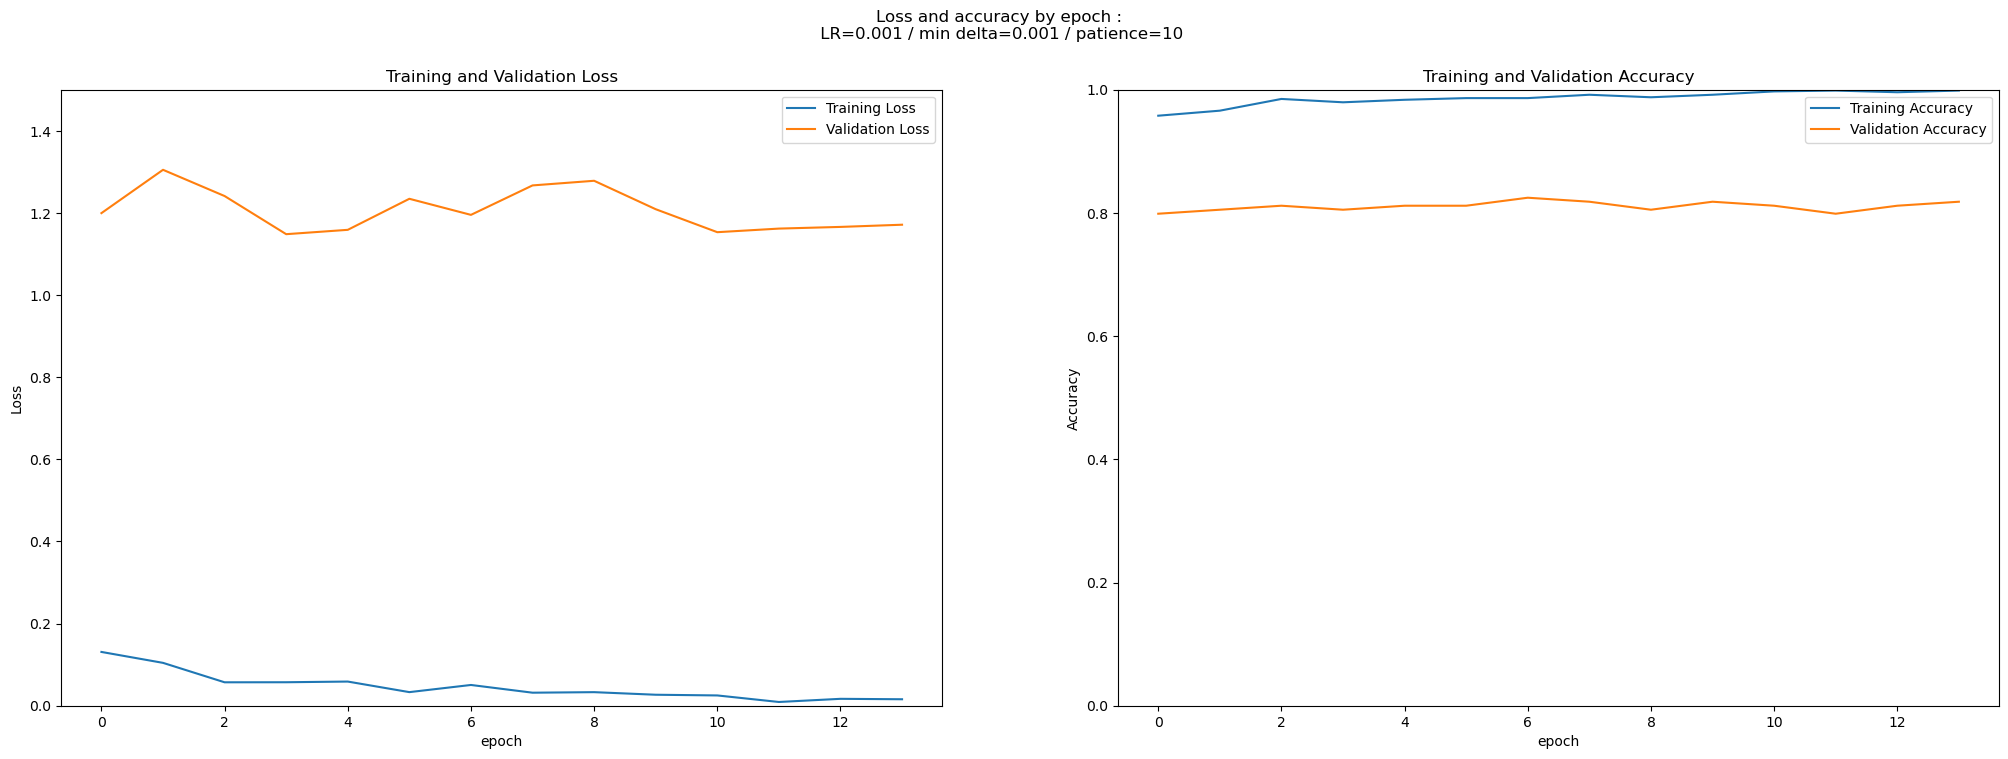

In [90]:
fig, ax = plt.subplots(1, 2, figsize=(25, 8))

# plotting loss
ax[0].plot(history_frame['loss'], label='Training Loss')
ax[0].plot(history_frame['val_loss'], label='Validation Loss')
ax[0].legend(loc='upper right')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,1.5])
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('epoch')

# plotting accuracy
ax[1].plot(history_frame['accuracy'], label='Training Accuracy')
ax[1].plot(history_frame['val_accuracy'], label='Validation Accuracy')
ax[1].legend(loc='upper right')
ax[1].set_ylabel('Accuracy')
ax[1].set_ylim([0,1.5])
ax[1].set_title('Training and Validation Accuracy')
ax[1].set_xlabel('epoch')


plt.suptitle('Loss and accuracy by epoch :\n LR='+str(model.optimizer.learning_rate.numpy())+" / min delta="+str(min_improvement)+" / patience="+str(epochs_to_wait))
plt.show()

### Classification

In [220]:
#Predicting classes on our test dataset
final = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [222]:
#preparing a dictionnary to replace numerical values with labels
class_names=X_test.class_names
replace_dict = {i: class_names[i] for i in range(len(class_names))}

#using dictionnary 
final_classes=[np.argmax(i) for i in final]
final_classes=[replace_dict[i] for i in final_classes]

In [226]:
#testing prediction
print("Predicted category:", final_classes[5])

Predicted category: Baby Care


In [228]:
#Evaluation of model viability
loss, accuracy = model.evaluate(X_test, verbose=0)
print("Test accuracy:", np.round(accuracy * 100, 2), "%")

Test accuracy: 78.88 %
